In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# global defaults for plots - optional
sns.set_theme(style="ticks",
              palette="Set2",
              font_scale=1.7,
              rc={
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

## Exercise 1.1 The leaky integrate and fire neuron

In Lab 1 we simulated the passive membrane dynamics of a neuron:

$$ \tau \frac{\mathrm{d}V}{\mathrm{d}t} = -(V-E_m) + \frac{I_{ext}}{g_m} $$

The leaky integrate and fire model obeys the above equation while below spiking threshold. Now, we will add spikes to the model. To do so, we add the following spike-reset rule: if $V (t) \geq V_{threshold}$ then we immediately set $V (t) \to V_{reset}$.

* Modify the code for the passive dynamics in Lab 1 to incorporate this spike-reset rule. To do this, you can add an if-then statement inside your loop over time steps. You will also need to store spike times for later use. Using this code, set $V_{threshold} = −50$ mV, $V_{reset} = −75$ mV and try running the simulation with different values of input current and time constant and plot the membrane potential in each case.

How does each parameter influence the spiking activity?


In [31]:
# LIF neuron class
class LIF_Neuron:
    """
    Leaky Integrate-and-Fire Neuron
    """
    def __init__(self):
        # simulation params
        self.n_neurons = 1
        # neuron params
        self.V_init = -70
        self.E_m = -70
        self.tau = 10
        self.g_m = 1
        self.I_ext = 21
        self.V_theta = -50
        self.V_reset = -75
        # results
        self.V = np.array([])
        self.spikes = np.array([])
        self.spike_times = np.array([])
    
    def euler_solve(self, N_t, dt,  V_init, I_ext, tau):
        """
        Euler method to numerically solve LIF neuron ODE
        N_t: number of time steps
        dt: time step size
        V_init: initial membrane potential vector
        I_ext: external current vector
        tau: time constant vector
        """
        self.n_neurons = V_init.shape[0]
        # N_t+1 rows (N_t+init), n_neurons columns
        # Column is V of a SPECIFIC neuron OVER time
        # Row is V for ALL neurons AT a particular time
        V = np.zeros([N_t+1, self.n_neurons])
        V[0,:] = V_init[:]
        spikes = np.zeros(V.shape)
        # 
        for t in range(1,N_t+1):
            dV = (-(V[t-1] - self.E_m) + I_ext/self.g_m)
            V[t] = V[t-1] + dt * dV / tau
            # check spike and reset
            spiked = (V[t] >= self.V_theta)
            # boolean value selector
            V[t] = self.V_reset * spiked + V[t] * (spiked == 0)
            # record a spike at t
            spikes[t] = spiked * 1.0
        
        # save results
        self.V = V
        self.spikes = spikes
        self.extract_spike_times()
    
    def extract_spike_times(self):
        """
        Extract spike times from neuron-spike matrix
        """
        spike_times = []
        for n in range(self.n_neurons):
            # if any spikes in neuron n (column n)
            if np.any(self.spikes[:,n] == 1.0):
                # extracts indices of spikes (time steps)
                spike_time_steps = np.nonzero(self.spikes[:,n])
            else:
                spike_time_steps = np.array([])
            print(spike_time_steps)
            spike_times.append(spike_time_steps)
        self.spike_times = spike_times

    def compute_ISI(self):
        """
        Compute Inter-Spike Interval
        """
        for n in range(self.n_neurons):
            spike_times = self.spike_times[n]
            if spike_times.size < 2:
                return None
            isi = np.diff(spike_times)
            return isi
        
    def simulate(self, n_params, values):
        combs = n_params * values
        N_t = 10000
        dt = 0.1

        V_inits = np.zeros([combs])
        V_inits[:] = self.V_init
        taus = np.zeros([combs]) + self.tau
        taus[:values] =  np.linspace(1,100, values)
        I_exts = np.zeros([combs]) + self.I_ext
        I_exts[values:] = np.linspace(0,30,5)
        print(V_inits)
        print()
        print(taus)
        print()
        print(I_exts)
        self.euler_solve(N_t, dt, V_inits, I_exts, taus)



In [32]:
# Simulation
neuron = LIF_Neuron()
neuron.simulate(n_params=2, values=5)


[-70. -70. -70. -70. -70. -70. -70. -70. -70. -70.]

[  1.    25.75  50.5   75.25 100.    10.    10.    10.    10.    10.  ]

[21.  21.  21.  21.  21.   0.   7.5 15.  22.5 30. ]
(array([  29,   60,   91,  122,  153,  184,  215,  246,  277,  308,  339,
        370,  401,  432,  463,  494,  525,  556,  587,  618,  649,  680,
        711,  742,  773,  804,  835,  866,  897,  928,  959,  990, 1021,
       1052, 1083, 1114, 1145, 1176, 1207, 1238, 1269, 1300, 1331, 1362,
       1393, 1424, 1455, 1486, 1517, 1548, 1579, 1610, 1641, 1672, 1703,
       1734, 1765, 1796, 1827, 1858, 1889, 1920, 1951, 1982, 2013, 2044,
       2075, 2106, 2137, 2168, 2199, 2230, 2261, 2292, 2323, 2354, 2385,
       2416, 2447, 2478, 2509, 2540, 2571, 2602, 2633, 2664, 2695, 2726,
       2757, 2788, 2819, 2850, 2881, 2912, 2943, 2974, 3005, 3036, 3067,
       3098, 3129, 3160, 3191, 3222, 3253, 3284, 3315, 3346, 3377, 3408,
       3439, 3470, 3501, 3532, 3563, 3594, 3625, 3656, 3687, 3718, 3749,
       3780, 3811,

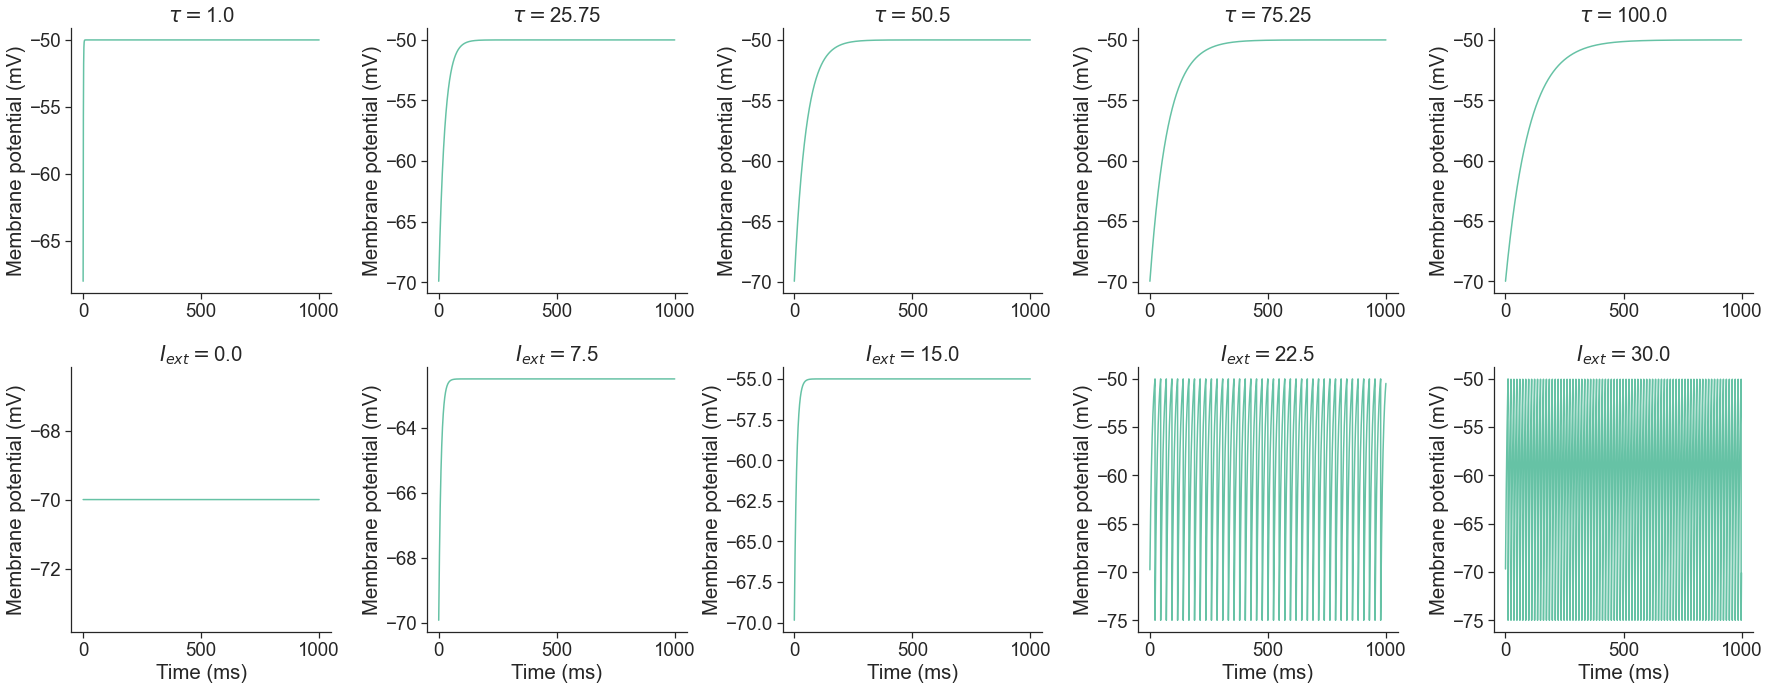

In [30]:
# Figures
n_params = 2
values = 5
combs = n_params * values
N_t = 10000
dt = 0.1

taus = np.zeros([combs]) + neuron.tau
taus[:values] =  np.linspace(1,100, values)
I_exts = np.zeros([combs]) + neuron.I_ext
I_exts[values:] = np.linspace(0,30,5)
V_spike = neuron.V

fig, ax = plt.subplots(n_params,values, figsize = (25,10))
for i in range(values):
    ax[0,i].plot(np.arange(0,N_t*dt, dt),V_spike[1:,i])
    ax[0,i].set_title('$\\tau =$'+str(taus[i]))
    ax[1,i].plot(np.arange(0,N_t*dt, dt),V_spike[1:,i+values])
    ax[1,i].set_title('$I_{ext} =$'+str(I_exts[i+values]))
    ax[0,i].ticklabel_format(useOffset=False, style = 'plain')
    ax[1,i].ticklabel_format(useOffset=False, style = 'plain')
    ax[0,i].set_ylabel('Membrane potential (mV)')
    ax[1,i].set_ylabel('Membrane potential (mV)')
    ax[1,i].set_xlabel('Time (ms)')

fig.tight_layout()
plt.show()